In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tensorflow as tf
from utils import regression, regression_plot

In [4]:
x = np.linspace(-10, 10, 10000) # start, finish, n points

def my_fxn(my_x):
    my_y = (my_x**2 - 1)/(my_x - 1)
    return my_y

In [9]:
# Using the delta method, find the slope of the tangent where x = -1
delta = 1e-06

x1 = -1
y1 = my_fxn(x1)

x2 = x1 + delta
y2 = my_fxn(x2)

# This 1.00000e-06 is practically zero.
m = (y2-y1) / (x2-x1)

m

1.000000000011061

## Automatic differentiation (autodiff) in Pytorch

In [12]:
x = torch.tensor(5.0)

# Contagiuosly track gradients through forward pass.
# Any variable created by the function of x or derives from some operation involving
# this 'x', it will also be tracked (contagiuosly).
# This takes extra memory, so its disabled by default.
x.requires_grad_()

# y = x²
y = x**2
print(y) # Check the grad_fn attribute

y.backward() # use autodiff

# dy/dx = 2x = 2(5) = 10
print(x.grad) # result of calculating the derivative of the previous function

tensor(25., grad_fn=<PowBackward0>)


tensor(10.)

## Automatic differentiation (autodiff) in Tensorflow

In [2]:
x = tf.Variable(5.0)

# We can't track gradients globally in TF
# We need to define a scope for this
with tf.GradientTape() as t:
    t.watch(x) # track forward pass

    y = x** 2

t.gradient(y, x) # use autodiff

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

## Machine learning training with Autodiff in Pytorch

1) Do forward pass
2) Compare y_hat with true y to calculate cost **C** (loss)
3) Use chain rule to calculate gradient of **C** 
4) Adjust ***b*** to reduce **C**

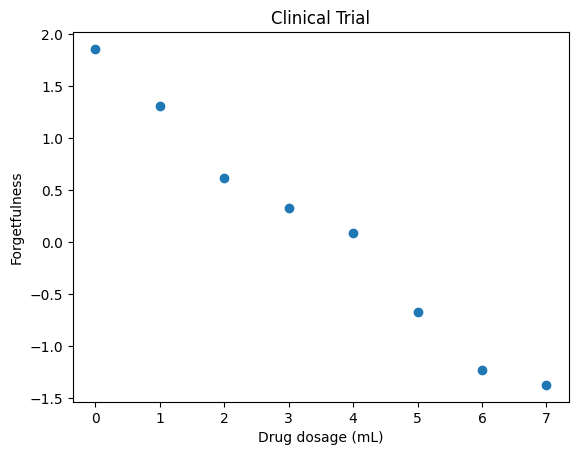

In [25]:
x = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7.]) # E.g.:Dosage of drug for treating Alzheimer's disease

# Fixed example of y values (random values)
y= torch.tensor([1.86, 1.31, .62, .33, .09, -.67, -1.23, -1.37]) # E.g.: Patient's "forgetfulness score"

fig, ax = plt.subplots()
plt.title("Clinical Trial")
plt.xlabel("Drug dosage (mL)")
plt.ylabel("Forgetfulness")
_ = ax.scatter(x, y)

In [26]:
# Random values to start with
m = torch.tensor([0.9]).requires_grad_()
# y-intercept parameter b
b = torch.tensor([0.1]).requires_grad_()

#### Step 1. Forward pass

In [28]:
yhat = regression(x, m, b)
yhat

tensor([0.1000, 1.0000, 1.9000, 2.8000, 3.7000, 4.6000, 5.5000, 6.4000],
       grad_fn=<AddBackward0>)

#### Step 2. Compare yhat with true y to calculate cost C
We can calculate the absolute value of the difference between true and predicted, as a starting point, but MSE works better. We square the difference (so it will always
be positive), and the bigger the difference, the larger the cost, so its exponential.

We tolerate small differences, but not larger ones. It guides better the model learning.

In [29]:
# Define custom Pytorch MSELoss (Mean Squared Error Loss)
def mse(my_yhat, my_y):
    sigma = torch.sum((my_yhat - my_y) ** 2)

    return sigma/len(my_y)

In [30]:
C = mse(yhat, y)
print(f"Current loss: {C}")

Current loss: 19.675472259521484


#### Step 3: Use autodiff to calculate gradient of c w.r.t. parameters

In [31]:
C.backward()

In [32]:
m.grad

tensor([36.3050])

In [33]:
b.grad

tensor([6.2650])

#### Step 4: Gradient descent

In [34]:
# Stochastic Gradient Descent
# We pass the model parameters we want to adjust, and the learning rate.
# The learning rate corresponds with how much we adjust parameters
optimizer = torch.optim.SGD([m, b], lr=0.01)

# Perform a step, adjusting m and b
optimizer.step()

In [35]:
m

tensor([0.5369], requires_grad=True)

In [36]:
b

tensor([0.0374], requires_grad=True)

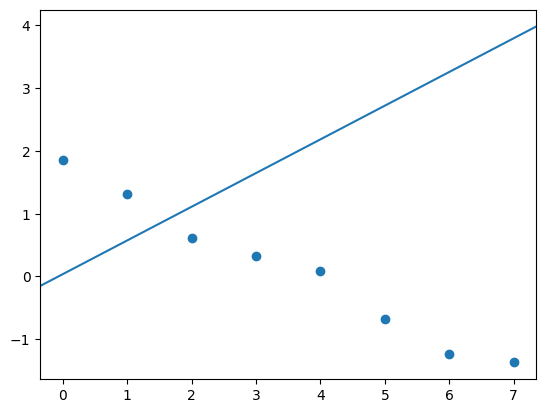

In [38]:
regression_plot(x, y, m, b)

#### Step 5: Iteratively minimize cost toward zero (training)

In [40]:
epochs = 1000
plot_interval = 100 # plot each 100 epochs
for epoch in range(epochs):
    # Reset gradients of optimized tensors, to avoid accumulation
    optimizer.zero_grad()

    yhat = regression(x, m, b) # Step 1
    C = mse(yhat, y) # Step 2

    C.backward() # Step 3
    optimizer.step() # Step 4

    if epoch % plot_interval == 0:
        print(f"Epoch: {epoch} | Cost: {C.item()} | M grad {m.grad.item()} | B grad {b.grad.item()}")

Epoch: 0 | Cost: 0.01947583258152008 | M grad 0.0006683170795440674 | B grad -0.0032886117696762085
Epoch: 100 | Cost: 0.01946915127336979 | M grad 0.0003750026226043701 | B grad -0.0018443763256072998
Epoch: 200 | Cost: 0.019467033445835114 | M grad 0.00020971894264221191 | B grad -0.001034662127494812
Epoch: 300 | Cost: 0.019466370344161987 | M grad 0.00011876225471496582 | B grad -0.0005799978971481323
Epoch: 400 | Cost: 0.019466159865260124 | M grad 6.636977195739746e-05 | B grad -0.0003254115581512451
Epoch: 500 | Cost: 0.019466105848550797 | M grad 3.674626350402832e-05 | B grad -0.0001827031373977661
Epoch: 600 | Cost: 0.019466079771518707 | M grad 2.244114875793457e-05 | B grad -0.00010214745998382568
Epoch: 700 | Cost: 0.019466081634163857 | M grad 1.3023614883422852e-05 | B grad -5.747377872467041e-05
Epoch: 800 | Cost: 0.019466068595647812 | M grad 7.778406143188477e-06 | B grad -3.235042095184326e-05
Epoch: 900 | Cost: 0.01946607045829296 | M grad 4.708766937255859e-06 | B 

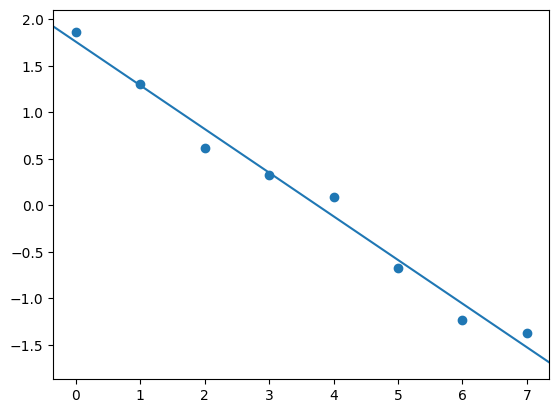

In [41]:
regression_plot(x, y, m, b)

## Exercises

In [47]:
# Find the slope of y = x² + 2x + 2 where x = 2
x = torch.tensor(2.)

def fn(x):
    return x**2 + 2*x + 2

x.requires_grad_()

y = fn(x)
y

tensor(10., grad_fn=<AddBackward0>)

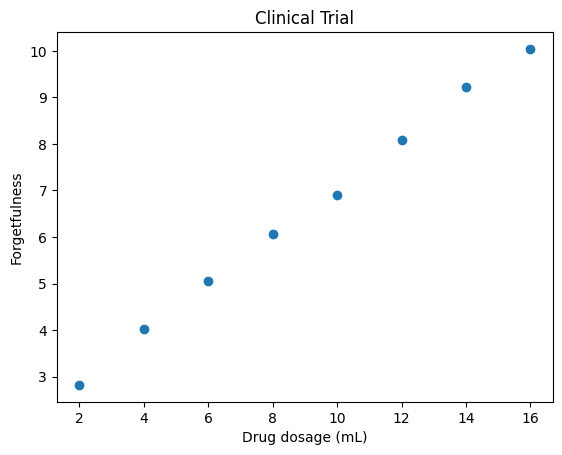

In [24]:
# Create own X and Y and try to fit it
x = torch.tensor([2, 4, 6, 8, 10, 12, 14, 16.]) # E.g.: Some X training data

# y = m*x + b
y = 0.5*x + 2 + torch.normal(mean=torch.zeros(len(x)), std=0.2) # plus some random noise

fig, ax = plt.subplots()
plt.title("Clinical Trial")
plt.xlabel("Drug dosage (mL)")
plt.ylabel("Forgetfulness")
_ = ax.scatter(x, y)

Epoch: 0 | Cost: 5.924348831176758 | m: 46.2838134765625 | b: 3.343275308609009
Epoch: 1000 | Cost: 0.3085329532623291 | m: 0.04365372657775879 | b: -0.49373847246170044
Epoch: 2000 | Cost: 0.14064998924732208 | m: 0.029012441635131836 | b: -0.32810860872268677
Epoch: 3000 | Cost: 0.06651054322719574 | m: 0.019272685050964355 | b: -0.21804165840148926
Epoch: 4000 | Cost: 0.03376982361078262 | m: 0.012818455696105957 | b: -0.14489668607711792
Epoch: 5000 | Cost: 0.019311031326651573 | m: 0.008522629737854004 | b: -0.09628945589065552
Epoch: 6000 | Cost: 0.012925805523991585 | m: 0.005678415298461914 | b: -0.06398677825927734
Epoch: 7000 | Cost: 0.010106027126312256 | m: 0.003773212432861328 | b: -0.04252219200134277
Epoch: 8000 | Cost: 0.008860730566084385 | m: 0.002518296241760254 | b: -0.028256714344024658
Epoch: 9000 | Cost: 0.008310811594128609 | m: 0.001671910285949707 | b: -0.01877802610397339


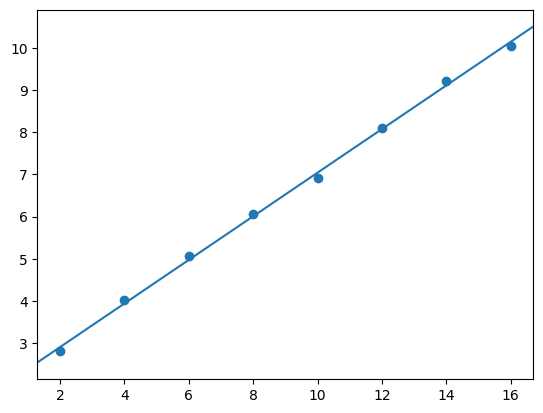

In [30]:
# Train a model to predict that

# MSE cost
def calculate_cost(y_hat, y):
    sigma = torch.sum((y_hat - y) ** 2)
    return sigma/len(y)

def regression(x, m, b):
    return x*m + b

# Initialize weights and biases with random values
m = torch.tensor([0.9]).requires_grad_()
b = torch.tensor([0.1]).requires_grad_()

optim = torch.optim.SGD([m, b], lr=0.001)

epochs = 10000
plot_interval = 1000

for epoch in range(epochs):
    optim.zero_grad()

    y_hat = regression(x, m, b)
    C = calculate_cost(y_hat, y)

    C.backward()
    optim.step()

    if epoch % plot_interval == 0:
        print(f"Epoch: {epoch} | Cost: {C.item()} | m: {m.grad.item()} | b: {b.grad.item()}")

regression_plot(x, y, m, b)